<a href="https://colab.research.google.com/github/ldorje1/ldorje1.github.io/blob/master/mobileVIT_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### (1) Core MobileVIT Model;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# HFFH_ViT: Hybrid Freehand Imaging ViT (MobileViT-style)
# Approximation faithful to the printed architecture you gave
# Input:  (B, 1, H, W)
# Output: (B, 1, H, W)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Core transformer components ----------

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        # x: (B, N, dim)
        return self.fn(self.norm(x))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=8, dropout=0.0):
        """
        dim: token embedding dim (8 or 16 in HFFH_ViT)
        heads: 4, so 3 * heads * dim_head = 96 = to_qkv out_features
        dim_head: 8
        """
        super().__init__()
        inner_dim = dim_head * heads * 3  # for q, k, v
        self.heads = heads
        self.dim_head = dim_head

        self.to_qkv = nn.Linear(dim, inner_dim, bias=False)
        self.attend = nn.Softmax(dim=-1)
        self.to_out = nn.Sequential(
            nn.Linear(dim_head * heads, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        x: (B, N, dim)
        """
        b, n, _ = x.shape
        qkv = self.to_qkv(x)  # (B, N, 3 * heads * dim_head)
        qkv = qkv.view(b, n, 3, self.heads, self.dim_head)
        q, k, v = qkv.unbind(dim=2)  # each: (B, N, heads, dim_head)

        # (B, heads, N, dim_head)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        scale = self.dim_head ** -0.5
        dots = torch.matmul(q, k.transpose(-1, -2)) * scale  # (B, heads, N, N)
        attn = self.attend(dots)
        out = torch.matmul(attn, v)                           # (B, heads, N, dim_head)

        # (B, N, heads * dim_head)
        out = out.permute(0, 2, 1, 3).contiguous().view(b, n, self.heads * self.dim_head)
        out = self.to_out(out)  # (B, N, dim)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, depth, mlp_dim, heads=4, dim_head=8, dropout=0.0):
        """
        dim: token dimension (8 or 16)
        depth: number of transformer layers
        mlp_dim: hidden dim in FFN (paper uses ~2x or 4x)
        """
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = x + attn(x)
            x = x + ff(x)
        return x


In [ ]:
# ---------- MobileViT-style blocks ----------

class MV2Block(nn.Module):
    """
    MobileNetV2-style depthwise separable block.
    Matches the printed pattern:
      Conv2d(C,C,3x3,groups=C) -> BN -> SiLU -> Conv2d(C,C or C->C') -> BN
    With residual if in==out and stride==1.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                      padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.use_res_connect = (stride == 1 and in_channels == out_channels)

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out


class MobileViTBlock(nn.Module):
    """
    MobileViT-style block:
      conv1: 3x3 (C->C)
      conv2: 1x1 (C->transformer_dim)
      transformer over patches in token dim = transformer_dim
      conv3: 1x1 (transformer_dim->C)
      conv4: 3x3 on concat(local, global) (2C->C)

    patch_size controls how big each transformer patch is (e.g., (2,2) or (4,4)).
    """
    def __init__(self, in_channels, transformer_dim, depth,
                 patch_size=(2, 2), mlp_dim=None, heads=4, dim_head=8, dropout=0.0):
        super().__init__()
        ph, pw = patch_size
        self.patch_h = ph
        self.patch_w = pw
        self.transformer_dim = transformer_dim

        # Local conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=False),
        )

        # Channel projection: C -> transformer_dim (8 or 16)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, transformer_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(transformer_dim),
            nn.SiLU(inplace=False),
        )

        if mlp_dim is None:
            mlp_dim = transformer_dim * 2  # you can change to *4 if you want to mimic 4x layers

        self.transformer = Transformer(
            dim=transformer_dim,
            depth=depth,
            mlp_dim=mlp_dim,
            heads=heads,
            dim_head=dim_head,
            dropout=dropout,
        )

        # Back to conv space: transformer_dim -> in_channels
        self.conv3 = nn.Sequential(
            nn.Conv2d(transformer_dim, in_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=False),
        )

        # Fuse local+global: (2C -> C)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=False),
        )

    def forward(self, x):
        # x: (B, C, H, W)
        local_x = self.conv1(x)
        y = self.conv2(local_x)   # (B, transformer_dim, H, W)
        B, C, H, W = y.shape
        assert C == self.transformer_dim

        ph, pw = self.patch_h, self.patch_w

        # Pad so H,W divisible by patch size
        pad_h = (ph - H % ph) % ph
        pad_w = (pw - W % pw) % pw
        if pad_h != 0 or pad_w != 0:
            y = F.pad(y, (0, pad_w, 0, pad_h), mode="reflect")
            B, C, H, W = y.shape

        self._orig_hw = (H, W)

        # Unfold into non-overlapping patches
        # y_unfold: (B, C*ph*pw, L)
        y_unfold = F.unfold(y, kernel_size=(ph, pw), stride=(ph, pw))
        # reshape to (B, C, ph*pw, L) then average over patch pixels -> (B, C, L)
        y_unfold = y_unfold.view(B, C, ph * pw, -1).mean(dim=2)
        # tokens: (B, L, C)
        tokens = y_unfold.permute(0, 2, 1).contiguous()

        # Transformer over tokens
        tokens = self.transformer(tokens)  # (B, L, C)

        # Map tokens back to patches, broadcast to ph*pw pixels, fold back
        t = tokens.permute(0, 2, 1)                 # (B, C, L)
        t = t.unsqueeze(2).repeat(1, 1, ph * pw, 1) # (B, C, ph*pw, L)
        t = t.view(B, C * ph * pw, -1)              # (B, C*ph*pw, L)
        y = F.fold(t, output_size=(H, W), kernel_size=(ph, pw), stride=(ph, pw))

        # Crop to original (if we padded)
        orig_H, orig_W = self._orig_hw
        y = y[:, :, :orig_H, :orig_W]

        # Project back and fuse with local conv features
        y = self.conv3(y)
        out = torch.cat((x, y), dim=1)
        out = self.conv4(out)
        return out



In [ ]:
# ---------- HFFH_ViT full network ----------

class HFFH_ViT(nn.Module):
    """
    Hybrid Freehand Imaging ViT
    - Input:  (B, 3, H, W)
    - Output: (B, 3, H, W)
    Matches the high-level structure you pasted:
      conv1: 1->16
      stem:  4x MV2Block(16->16)
      trunk:
        Stage1: MV2(16->16) + MobileViTBlock(16,8,depth=2)
        Stage2: MV2(16->16) + MobileViTBlock(16,8,depth=4)
        Stage3: MV2(16->32) + MobileViTBlock(32,16,depth=3)
      head:  1x1 conv 32->1
    """
    def __init__(self, img_channels=3, patch_size=(2, 2), dropout=0.0):
        super().__init__()

        # # Initial conv: img_channels -> 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(img_channels, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU(inplace=False),
        )

        # Stem: 4× MV2Block(16->16)
        self.stem = nn.ModuleList([
            MV2Block(16, 16, stride=1),
            MV2Block(16, 16, stride=1),
            MV2Block(16, 16, stride=1),
            MV2Block(16, 16, stride=1),
        ])

        # Trunk: 3 stages
        self.trunk = nn.ModuleList()

        # Stage 1: channels 16, transformer_dim=8, depth=2 (as in printout)
        stage1 = nn.ModuleList([
            MV2Block(16, 16, stride=1),
            MobileViTBlock(
                in_channels=16,
                transformer_dim=8,
                depth=2,
                patch_size=patch_size,
                mlp_dim=16,      # 2x expansion for dim=8
                heads=4,
                dim_head=8,
                dropout=dropout,
            )
        ])
        self.trunk.append(stage1)

        # Stage 2: channels 16, transformer_dim=8, depth=4
        stage2 = nn.ModuleList([
            MV2Block(16, 16, stride=1),
            MobileViTBlock(
                in_channels=16,
                transformer_dim=8,
                depth=4,
                patch_size=patch_size,
                mlp_dim=32,      # 4x expansion for dim=8
                heads=4,
                dim_head=8,
                dropout=dropout,
            )
        ])
        self.trunk.append(stage2)

        # Stage 3: MV2 16->32, transformer_dim=16, depth=3
        stage3 = nn.ModuleList([
            MV2Block(16, 32, stride=1),
            MobileViTBlock(
                in_channels=32,
                transformer_dim=16,
                depth=3,
                patch_size=patch_size,
                mlp_dim=64,      # 4x expansion for dim=16
                heads=4,
                dim_head=8,
                dropout=dropout,
            )
        ])
        self.trunk.append(stage3)

        # Head: 32 -> 3
        '''
        self.condense_channels = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 1, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(1),
                nn.SiLU(inplace=False),
            )
        )
        '''
        # Head: 32 -> 3
        self.condense_channels = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 3, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(3),
                nn.SiLU(inplace=False),
            )
        )


    def forward(self, x):
        # x: (B,img_channels,H,W)
        x = self.conv1(x)  # (B,16,H,W)

        for block in self.stem:
            x = block(x)    # (B,16,H,W)

        # Trunk stages
        for stage in self.trunk:
            mv2, mvblock = stage
            x = mv2(x)
            x = mvblock(x)

        # Now 32 channels -> 1
        out = self.condense_channels(x)
        return out


# ---------- Sanity check in Colab ----------
'''
if __name__ == "__main__":
    model = HFFH_ViT(img_channels=1, patch_size=(2, 2), dropout=0.0)
    x = torch.randn(1, 1, 256, 256)  # dummy SAR magnitude
    y = model(x)
    print("Input shape :", x.shape)
    print("Output shape:", y.shape)
    print("Num params  :", sum(p.numel() for p in model.parameters()))
'''

'\nif __name__ == "__main__":\n    model = HFFH_ViT(img_channels=1, patch_size=(2, 2), dropout=0.0)\n    x = torch.randn(1, 1, 256, 256)  # dummy SAR magnitude\n    y = model(x)\n    print("Input shape :", x.shape)\n    print("Output shape:", y.shape)\n    print("Num params  :", sum(p.numel() for p in model.parameters()))\n'

### (2) Load dataset and training loop

*<font color="orange"> Note: DO NOT RUN THIS! The trained model is already available.</font> *

In [ ]:
from pathlib import Path

# Path to your "data" folder in Drive
root = Path('/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data')

lr_dir = root / 'LR'
hr_dir = root / 'HR'

print("LR path:", lr_dir)
print("HR path:", hr_dir)

# Quick sanity check
print("Num LR jpg:", len(list(lr_dir.glob('*.jpg'))))
print("Num HR jpg:", len(list(hr_dir.glob('*.jpg'))))

LR path: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data/LR
HR path: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data/HR
Num LR jpg: 5000
Num HR jpg: 5000


#### (only need to run once) split into train / val / test

In [ ]:
import os
import random
import shutil
from pathlib import Path

# =-------------> NOTE: I COMMENT THIS OUT BC I ONLY RUN IT ONCE

'''
# ---------- 1) Paths ----------
root = Path('/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data')
lr_dir = root / 'LR'
hr_dir = root / 'HR'
ext = '.jpg'   # change if needed

assert lr_dir.exists(), f"LR not found: {lr_dir}"
assert hr_dir.exists(), f"HR not found: {hr_dir}"

print("LR dir:", lr_dir)
print("HR dir:", hr_dir)

# ---------- 2) Collect filenames and build base IDs ----------
def get_base_id(fname: str):
    """Strip _LR or _HR from stem to get common ID."""
    stem = Path(fname).stem          # e.g. 'img_1_LR'
    if stem.endswith('_LR'):
        return stem[:-3]             # 'img_1'
    if stem.endswith('_HR'):
        return stem[:-3]             # 'img_1'
    return stem                      # fallback

# LR files
lr_files = sorted([f.name for f in lr_dir.glob(f'*{ext}')])
# HR files
hr_files = sorted([f.name for f in hr_dir.glob(f'*{ext}')])

print(f"Found {len(lr_files)} LR files, {len(hr_files)} HR files")

# Map base_id -> filename for LR and HR
lr_map = {}
for fname in lr_files:
    base = get_base_id(fname)
    lr_map[base] = fname

hr_map = {}
for fname in hr_files:
    base = get_base_id(fname)
    hr_map[base] = fname

# Intersection of base IDs that exist in BOTH
common_ids = sorted(set(lr_map.keys()) & set(hr_map.keys()))
n_total = len(common_ids)
print(f"Found {n_total} paired base IDs")

if n_total == 0:
    raise RuntimeError("No matching base IDs between LR and HR. Check naming!")

# ---------- 3) Shuffle + define splits ----------
random.seed(1234)  # reproducible
random.shuffle(common_ids)

# For 5000: 4000 / 500 / 500
n_train = 4000 if n_total >= 5000 else int(0.8 * n_total)
n_val   = 500  if n_total >= 5000 else int(0.1 * n_total)
n_test  = n_total - n_train - n_val

train_ids = common_ids[:n_train]
val_ids   = common_ids[n_train:n_train + n_val]
test_ids  = common_ids[n_train + n_val:]

print(f"Split -> train: {len(train_ids)}, val: {len(val_ids)}, test: {len(test_ids)}")

splits = {
    'train': train_ids,
    'val':   val_ids,
    'test':  test_ids,
}

# ---------- 4) Create split folders ----------
for split in splits.keys():
    for sub in ['LR', 'HR']:
        (root / split / sub).mkdir(parents=True, exist_ok=True)

# ---------- 5) Copy or move paired files ----------
use_move = False   # True = move, False = copy (safer first time)

for split, base_ids in splits.items():
    print(f"Processing {split} ({len(base_ids)} IDs)")
    for base in base_ids:
        lr_fname = lr_map[base]   # e.g. 'img_1_LR.jpg'
        hr_fname = hr_map[base]   # e.g. 'img_1_HR.jpg'

        src_lr = lr_dir / lr_fname
        src_hr = hr_dir / hr_fname

        dst_lr = root / split / 'LR' / lr_fname
        dst_hr = root / split / 'HR' / hr_fname

        if use_move:
            shutil.move(str(src_lr), str(dst_lr))
            shutil.move(str(src_hr), str(dst_hr))
        else:
            shutil.copy2(str(src_lr), str(dst_lr))
            shutil.copy2(str(src_hr), str(dst_hr))

print("Done splitting!")

# ---------- 6) Quick verification ----------
for split in ['train', 'val', 'test']:
    n_lr = len(list((root / split / 'LR').glob(f'*{ext}')))
    n_hr = len(list((root / split / 'HR').glob(f'*{ext}')))
    print(f"{split}: {n_lr} LR, {n_hr} HR")

'''

LR dir: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data/LR
HR dir: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data/HR
Found 5000 LR files, 5000 HR files
Found 5000 paired base IDs
Split -> train: 4000, val: 500, test: 500
Processing train (4000 IDs)
Processing val (500 IDs)
Processing test (500 IDs)
Done splitting!
train: 4000 LR, 4000 HR
val: 500 LR, 500 HR
test: 500 LR, 500 HR


#### Data Processing

In [ ]:
# Copy your dataset from Drive → /content ---> FASTER PERFORMANCE

import os, shutil

src = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/data"
dst = "/content/data_local"

if not os.path.exists(dst):
    print("Copying data from Drive to local storage...")
    shutil.copytree(src, dst)
    print("Done copying.")
else:
    print("Local copy already exists:", dst)

Copying data from Drive to local storage...
Done copying.


In [ ]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch

class SARDataset(Dataset):
    """
    PyTorch dataset for paired SAR super-resolution.
    Loads matching LR/HR .jpg images from root_dir/split/LR and root_dir/split/HR,
    converts them to 3-channel RGB tensors, resizes to img_size×img_size, and returns
    (lr, hr) pairs for training/validation/testing.
    """

    def __init__(self, root_dir, split='train', img_size=256):
        self.root = Path(root_dir)
        self.lr_dir = self.root / split / 'LR'
        self.hr_dir = self.root / split / 'HR'

        # all LR filenames (we assume HR has matching names like img_1_HR.jpg, etc.)
        self.fnames = sorted([f.name for f in self.lr_dir.glob('*.jpg')])

        # Transforms: 514×514 -> 256×256, RGB, [0,1], shape (3,H,W)
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),  # this makes it similar to the paper
            T.ToTensor(),                    # (C,H,W) in [0,1]
        ])

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        lr_name = self.fnames[idx]
        hr_name = lr_name.replace('_LR', '_HR')  # because your naming is img_k_LR / img_k_HR

        lr_path = self.lr_dir / lr_name
        hr_path = self.hr_dir / hr_name

        # <-- IMPORTANT: keep the color info
        lr = Image.open(lr_path).convert('RGB')  # 3-channel RGB
        hr = Image.open(hr_path).convert('RGB')

        lr = self.transform(lr)  # (3,256,256)
        hr = self.transform(hr)

        return lr, hr


# root_dir etc. can stay the same:
root_dir = '/content/data_local'  # or your original path
img_size = 256

train_set = SARDataset(root_dir, split='train', img_size=img_size)
val_set   = SARDataset(root_dir, split='val',   img_size=img_size)
test_set  = SARDataset(root_dir, split='test',  img_size=img_size)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False, num_workers=0)

print(len(train_set), len(val_set), len(test_set))

4000 500 500


#### Load dataset

In [ ]:
# -----> Only run this to delete the data_local when the files are not copies properly
'''
import os, shutil

dst = "/content/data_local"

if os.path.exists(dst):
    print("Removing old incomplete copy...")
    shutil.rmtree(dst)
    print("Removed:", dst)
'''

Removing old incomplete copy...
Removed: /content/data_local


#### Training Loop

In [ ]:
from google.colab import drive
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import os

# --- 1. Import the standard progress bar library ---
from tqdm.auto import tqdm

#drive.mount('/content/drive')

save_dir = Path('/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models')
save_dir.mkdir(parents=True, exist_ok=True)
print("Saving to:", save_dir)

ckpt_path = save_dir / 'hffh_vit_ckpt.pth'

# --------------------- Model / Optimizer ---------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Assuming HFFH_ViT class is defined in a previous cell or imported
# If you get an error here, make sure the class definition is run before this block
model = HFFH_ViT(img_channels=3, patch_size=(8, 8), dropout=0.0).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
start_epoch = 0
best_val = float('inf')
best_epoch = -1

# --------------------- Try to RESUME ---------------------
if ckpt_path.exists():
    print(f"Found checkpoint at {ckpt_path}, loading...")
    checkpoint = torch.load(ckpt_path, map_location=device)

    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    start_epoch = checkpoint['epoch'] + 1
    best_val    = checkpoint.get('best_val', float('inf'))
    best_epoch  = checkpoint.get('best_epoch', -1)

    print(f"Resuming from epoch {start_epoch} "
          f"(previous best_val={best_val:.4e} at epoch {best_epoch})")
else:
    print("No checkpoint found, starting from scratch.")

# --------------------- Training Loop ---------------------
print(f"Starting training on {device}...")

for epoch in range(start_epoch, num_epochs):
    epoch_idx = epoch + 1

    # -------- Train --------
    model.train()
    train_loss = 0.0

    # Wrap the loader with tqdm for the progress bar
    # desc: Label at the start of the bar
    # leave: True means keep the bar on screen after finishing
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch_idx}/{num_epochs} [Train]", leave=True)

    for lr_img, hr_img in train_loop:
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)

        out = model(lr_img)
        loss = criterion(out, hr_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        train_loss += batch_loss * lr_img.size(0)

        # Update the progress bar with the current batch loss in real-time
        train_loop.set_postfix(loss=f"{batch_loss:.4f}")

    train_loss /= len(train_loader.dataset)

    # -------- Validate --------
    model.eval()
    val_loss = 0.0

    # Use leave=False for validation so it doesn't clutter the output (optional)
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch_idx}/{num_epochs} [Val]  ", leave=False)

    with torch.no_grad(): # Good practice to disable gradients for validation
        for lr_img, hr_img in val_loop:
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)

            out = model(lr_img)
            loss = criterion(out, hr_img)
            val_loss += loss.item() * lr_img.size(0)

    val_loss /= len(val_loader.dataset)

    # -------- Summary Print --------
    # We print the final averages here so they remain in the log history
    print(f" -> Train Loss: {train_loss:.4e} | Val Loss: {val_loss:.4e}")

    # -------- Track BEST model --------
    if val_loss < best_val:
        best_val = val_loss
        best_epoch = epoch_idx
        best_ckpt_path = save_dir / f"hffh_vit_best_epoch_{best_epoch:03d}.pth"
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"    *** Saved BEST model (epoch {best_epoch:03d}) ***")

    # -------- Save TRAINING CHECKPOINT for resume --------
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'best_val': best_val,
        'best_epoch': best_epoch,
    }
    torch.save(checkpoint, ckpt_path)

# -------- Save final model after training --------
final_ckpt_path = save_dir / f"hffh_vit_final_epoch_{num_epochs:03d}.pth"
torch.save(model.state_dict(), final_ckpt_path)
print(f"\nSaved FINAL model (epoch {num_epochs}) to {final_ckpt_path}")
print(f"Best epoch was {best_epoch} with val loss = {best_val:.4e}")

Saving to: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models
Found checkpoint at /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_ckpt.pth, loading...
Resuming from epoch 30 (previous best_val=1.7415e-02 at epoch 29)
Starting training on cuda...


Epoch 31/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 31/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8447e-02 | Val Loss: 1.7537e-02


Epoch 32/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 32/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8377e-02 | Val Loss: 1.7461e-02


Epoch 33/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 33/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8298e-02 | Val Loss: 1.7106e-02
    *** Saved BEST model (epoch 033) ***


Epoch 34/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 34/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8213e-02 | Val Loss: 1.7147e-02


Epoch 35/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 35/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8175e-02 | Val Loss: 1.7150e-02


Epoch 36/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 36/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8105e-02 | Val Loss: 1.7139e-02


Epoch 37/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 37/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.8102e-02 | Val Loss: 1.6984e-02
    *** Saved BEST model (epoch 037) ***


Epoch 38/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 38/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7924e-02 | Val Loss: 1.7089e-02


Epoch 39/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 39/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7984e-02 | Val Loss: 1.6777e-02
    *** Saved BEST model (epoch 039) ***


Epoch 40/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 40/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7790e-02 | Val Loss: 1.6924e-02


Epoch 41/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 41/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7786e-02 | Val Loss: 1.7030e-02


Epoch 42/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 42/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7623e-02 | Val Loss: 1.6417e-02
    *** Saved BEST model (epoch 042) ***


Epoch 43/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 43/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7652e-02 | Val Loss: 1.6711e-02


Epoch 44/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 44/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7589e-02 | Val Loss: 1.6573e-02


Epoch 45/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 45/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7547e-02 | Val Loss: 1.6712e-02


Epoch 46/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 46/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7469e-02 | Val Loss: 1.6496e-02


Epoch 47/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 47/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7342e-02 | Val Loss: 1.6755e-02


Epoch 48/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 48/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7413e-02 | Val Loss: 1.6790e-02


Epoch 49/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 49/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7384e-02 | Val Loss: 1.6375e-02
    *** Saved BEST model (epoch 049) ***


Epoch 50/50 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/50 [Val]  :   0%|          | 0/63 [00:00<?, ?it/s]

 -> Train Loss: 1.7286e-02 | Val Loss: 1.6089e-02
    *** Saved BEST model (epoch 050) ***

Saved FINAL model (epoch 50) to /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_final_epoch_050.pth
Best epoch was 50 with val loss = 1.6089e-02


#### Load your trained weights (best or final), and Run evaluation on your test set.

In [ ]:
import torch


# ----> Load the final (or best) model weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Recreate the model with EXACT same args used in training
model = HFFH_ViT(img_channels=3, patch_size=(8, 8), dropout=0.0).to(device)

# ---- Choose ONE of these paths ----
# Best model:
#ckpt_path = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_best_epoch_007.pth"

# Or final model:
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_final_epoch_050.pth"

# Load state dict (weights only)
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()   # VERY important for evaluation (disables dropout, etc.)

print("Loaded model from:", ckpt_path)

NameError: name 'HFFH_ViT' is not defined

In [ ]:
import torch.nn as nn

criterion = nn.L1Loss()   # same as training, for consistency

model.eval()
test_loss = 0.0
num_samples = 0

with torch.no_grad():
    for lr_img, hr_img in test_loader:
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)

        out = model(lr_img)
        loss = criterion(out, hr_img)

        batch_size = lr_img.size(0)
        test_loss += loss.item() * batch_size
        num_samples += batch_size

test_loss /= num_samples
print(f"Average Test L1 Loss: {test_loss:.4e}")


Average Test L1 Loss: 1.6469e-02


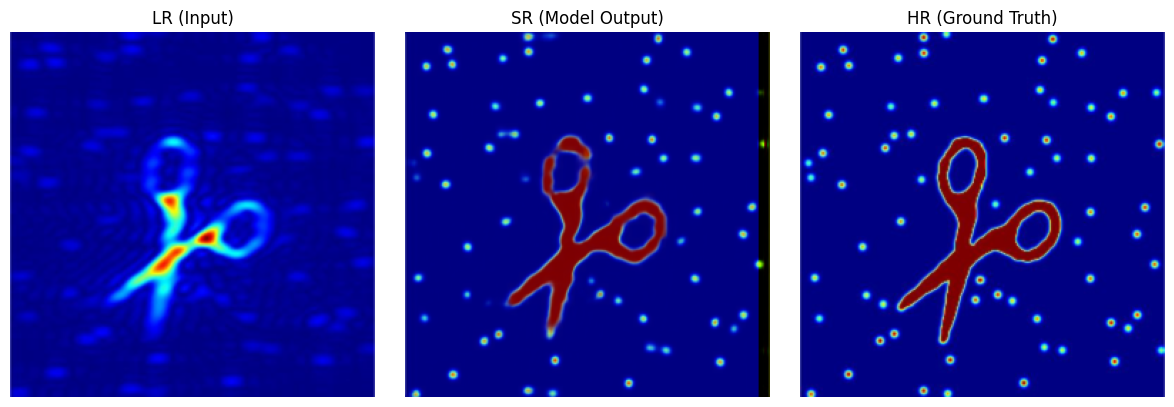

In [ ]:
import matplotlib.pyplot as plt

model.eval()
lr_img, hr_img = next(iter(test_loader))  # one batch
lr_img = lr_img.to(device)
hr_img = hr_img.to(device)

with torch.no_grad():
    sr_img = model(lr_img)

# Take first sample in batch, move to CPU and convert from (C,H,W) to (H,W,C)
idx = 3
lr_show = lr_img[idx].detach().cpu().permute(1, 2, 0).numpy()
hr_show = hr_img[idx].detach().cpu().permute(1, 2, 0).numpy()
sr_show = sr_img[idx].detach().cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(lr_show); plt.title("LR (Input)"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(sr_show); plt.title("SR (Model Output)"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(hr_show); plt.title("HR (Ground Truth)"); plt.axis('off')
plt.tight_layout()
plt.show()



### (3) Real SAR Measurement Imaging using trained MobileVIT (MFA)

rawSAR (torch complex) → range FFT → MFA (torch, autograd) → \hat{x}_0 → Mobile-ViT → image \hat{x}

*<font color="orange"> NOTE: please run (1) to define the mobileVIT mode, before running the attack </font> *

#### 3.1 Test the trained model on the real sar measurement.

trueImage_complex (MATLAB complex) → |x| → normalize [0,1] → jet colormap → RGB PIL image → resize 256×256 → PyTorch tensor → Mobile-ViT → super-resolved image


In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Recreate the model exactly as in training
model = HFFH_ViT(img_channels=3, patch_size=(8, 8), dropout=0.0).to(device)

ckpt_path = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_best_epoch_050.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Loaded Mobile-ViT from:", ckpt_path)

Loaded Mobile-ViT from: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models/hffh_vit_best_epoch_050.pth


In [ ]:
import scipy.io as sio
import numpy as np

mat_path = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/trueImage_complex.mat"   # change if different
mat = sio.loadmat(mat_path)

# This should be your 401x401 complex image
empm_complex = mat['trueImage_complex']       # shape (401, 401), complex
print(empm_complex.shape, empm_complex.dtype)

(401, 401) complex128


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# empm_complex: (401,401) complex
mag = np.abs(empm_complex).astype(np.float32)
mag /= (mag.max() + 1e-12)          # [0,1]

# --- APPLY JET COLORMAP LIKE YOUR SYNTHETIC LR IMAGES ---
cmap = plt.get_cmap('jet')
jet_rgb = cmap(mag)[..., :3]        # (H,W,3), float in [0,1]
jet_uint8 = (jet_rgb * 255).astype(np.uint8)

pil_rgb = Image.fromarray(jet_uint8)   # this now looks like your LR PNG

vit_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),                      # -> (3,256,256) in [0,1]
])

lr_tensor = vit_transform(pil_rgb).unsqueeze(0).to(device)  # (1,3,256,256)

In [ ]:
model.eval()
with torch.no_grad():
    sr_tensor = model(lr_tensor)

sr_img = sr_tensor[0].cpu().permute(1, 2, 0).numpy()
sr_img = np.clip(sr_img, 0.0, 1.0)

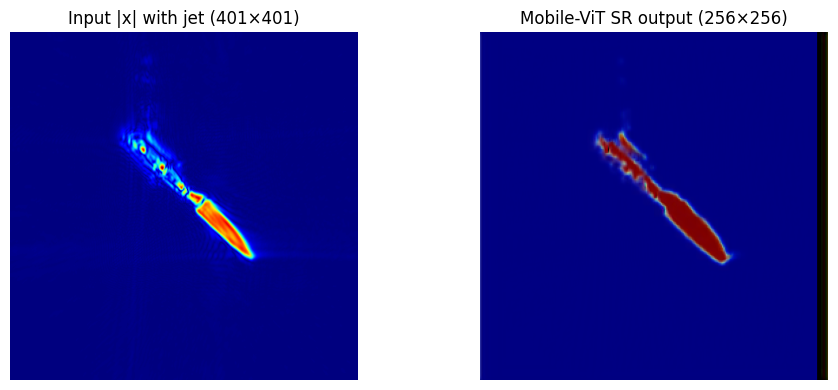

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(jet_rgb); plt.title("Input |x| with jet (401×401)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(sr_img);  plt.title("Mobile-ViT SR output (256×256)"); plt.axis('off')
plt.tight_layout(); plt.show()

#### 3.2 Define Match Filter Algortihm
rawSAR (torch complex) → range FFT → MFA (torch, autograd) → jet RGB → Mobile-ViT → image

In [ ]:
import torch
from dataclasses import dataclass

@dataclass
class MFAParams:
    F0: float          # start freq (Hz), e.g. 77e9
    c0: float          # lightspeed, e.g. 3e8
    dx: float          # mm
    dy: float          # mm
    z0_mm: float       # target range (mm)
    bbox: tuple        # (xmin, xmax, ymin, ymax) in mm
    FS: float          # sampling rate (Hz)
    K0: float          # chirp slope (Hz/s)
    tI: float          # instrument delay (s)
    nFFTtime: int      # range FFT size, e.g. 1024
    nFFTspace: int     # spatial FFT size, e.g. 1024

def build_matched_filter(params: MFAParams, device, dtype):
    """
    PyTorch version of refMF(params) in MATLAB.
    Returns: matchedFilter (nFFTspace x nFFTspace), complex tensor.
    """
    nF = params.nFFTspace
    dx_m = params.dx * 1e-3
    dy_m = params.dy * 1e-3
    z0_m = params.z0_mm * 1e-3

    # Index grid like MATLAB: (-(nF-1)/2 : (nF-1)/2) * dx
    # Equivalent: indices = i - (nF/2 - 0.5)
    idx = torch.arange(nF, device=device, dtype=dtype) - (nF / 2 - 0.5)
    x = dx_m * idx                          # (nF,)
    y = dy_m * idx.view(-1, 1)              # (nF,1) -> broadcast

    k = 2.0 * torch.pi * params.F0 / params.c0   # wavenumber
    R = torch.sqrt(x**2 + y**2 + z0_m**2)        # (nF, nF)

    phase = -1j * 2.0 * k * R                    # -j 2 k R
    matched_filter = torch.exp(phase)            # complex64/complex128
    return matched_filter

def mfa_image_from_slice(sarData: torch.Tensor, params: MFAParams):
    """
    Differentiable PyTorch version of dlMFA.
    sarData: (M, N) complex tensor (after range FFT + serpentine)
    Returns:
        img_mag_norm: (B, A) real tensor, RMS-normalized magnitude
        img_complex : (B, A) complex tensor
    """
    assert torch.is_complex(sarData), "sarData must be complex (torch.complex64/128)"
    device = sarData.device
    dtype  = sarData.real.dtype

    # Build matched filter on same device/dtype
    mf = build_matched_filter(params, device=device, dtype=dtype)  # (nF, nF)

    yPointM, xPointM = sarData.shape
    yPointF, xPointF = mf.shape   # both nFFTspace

    # --- zero-pad sarData up to matched filter size (like MATLAB) ---
    pad_y_pre = max((yPointF - yPointM) // 2, 0)
    pad_y_post = max(yPointF - yPointM - pad_y_pre, 0)
    pad_x_pre = max((xPointF - xPointM) // 2, 0)
    pad_x_post = max(xPointF - xPointM - pad_x_pre, 0)

    if pad_y_pre > 0 or pad_y_post > 0:
        pad_y_top = torch.zeros(pad_y_pre, xPointM, dtype=sarData.dtype, device=device)
        pad_y_bot = torch.zeros(pad_y_post, xPointM, dtype=sarData.dtype, device=device)
        sarData = torch.cat([pad_y_top, sarData, pad_y_bot], dim=0)

    if pad_x_pre > 0 or pad_x_post > 0:
        y_curr = sarData.shape[0]
        pad_x_left  = torch.zeros(y_curr, pad_x_pre, dtype=sarData.dtype, device=device)
        pad_x_right = torch.zeros(y_curr, pad_x_post, dtype=sarData.dtype, device=device)
        sarData = torch.cat([pad_x_left, sarData, pad_x_right], dim=1)

    # 2D FFT of data and matched filter
    sar_fft = torch.fft.fft2(sarData)
    mf_fft  = torch.fft.fft2(mf)

    # Convolution in freq domain, then ifft2
    img_shifted = torch.fft.ifft2(sar_fft * mf_fft)

    # fftshift (2D)
    def fftshift2d(x):
        h, w = x.shape[-2:]
        return torch.roll(torch.roll(x, shifts=h//2, dims=-2),
                          shifts=w//2, dims=-1)

    img = fftshift2d(img_shifted)

    # Crop using bbox like MATLAB
    J, I = img.shape
    bbox = params.bbox
    dx = params.dx
    dy = params.dy

    # x indices
    xij0 = round(bbox[0] / dx - 0.5 + I / 2.0)
    xij1 = round(bbox[1] / dx - 0.5 + I / 2.0)
    # y indices
    ykl0 = round(bbox[2] / dy - 0.5 + J / 2.0)
    ykl1 = round(bbox[3] / dy - 0.5 + J / 2.0)

    # convert to Python ints / clamp
    x0 = max(int(xij0), 0)
    x1 = min(int(xij1), I-1)
    y0 = max(int(ykl0), 0)
    y1 = min(int(ykl1), J-1)

    img_cropped = img[y0:y1+1, x0:x1+1]         # (B, A) complex

    # fliplr
    img_complex = torch.flip(img_cropped, dims=[1])

    # RMS-normalized magnitude (like trueImage_abs)
    mag = torch.abs(img_complex)
    rms = torch.sqrt(torch.mean(mag**2) + 1e-12)
    img_mag_norm = mag / rms

    return img_mag_norm, img_complex


In [ ]:
import scipy.io as sio
import numpy as np

# ---- 1) Load raw SAR from MATLAB ----
mat = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/rawSAR.mat")
raw_cube_np = mat["adcDataCube"]   # expecting shape (Nsamp, M, N), complex

# Convert to torch complex tensor
raw_cube = torch.from_numpy(raw_cube_np).to(torch.complex64).to(device)
Nsamp, M, N = raw_cube.shape

# ---- 2) Define MFA parameters (match your MATLAB values) ----
params = MFAParams(
    F0      = 77e9,
    c0      = 3e8,
    dx      = 1.0,
    dy      = 1.0,
    z0_mm   = 185.0,
    bbox    = (-200.0, 200.0, -200.0, 200.0),
    FS      = 5_000_000.0,
    K0      = 70.295e12,
    tI      = 4.5225e-10,
    nFFTtime  = 1024,
    nFFTspace = 1024,
)

# ---- 3) Range FFT along fast-time (dim=0) ----
raw_fft = torch.fft.fft(raw_cube, n=params.nFFTtime, dim=0)

# Compute range-bin index like in MATLAB
z0_m = params.z0_mm * 1e-3
k0_range_bin = round(
    params.K0 / params.FS * (2.0 * z0_m / params.c0 + params.tI) * params.nFFTtime
)
k0_range_bin = int(k0_range_bin)

# Extract slice at that range bin: (M, N)
sar_slice = raw_fft[k0_range_bin, :, :]   # complex

# Serpentine correction (flip every other row)
sar_slice = sar_slice.clone()
sar_slice[1::2, :] = torch.flip(sar_slice[1::2, :], dims=[1])

# ---- 4) Run differentiable MFA imaging ----
mfa_mag, mfa_complex = mfa_image_from_slice(sar_slice, params)  # (B,A)

print("MFA image shape:", mfa_mag.shape, mfa_complex.shape)


MFA image shape: torch.Size([401, 401]) torch.Size([401, 401])


In [ ]:

import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import numpy as np

# mfa_mag: (B,A) tensor (RMS-normalized but not guaranteed in [0,1])
mfa_mag_np = mfa_mag.detach().cpu().numpy()

# ---- explicit min-max normalization to [0,1] ----
mfa_mag_np = mfa_mag_np - mfa_mag_np.min()
mfa_mag_np /= (mfa_mag_np.max() + 1e-8)   # avoid divide-by-zero

# jet colormap (like synthetic LR images)
cmap = plt.get_cmap('jet')
jet_rgb = cmap(mfa_mag_np)[..., :3]          # (B,A,3), float in [0,1]
jet_uint8 = (jet_rgb * 255).astype(np.uint8)
pil_rgb = Image.fromarray(jet_uint8)

# same transform used in training (Resize + ToTensor)
vit_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),                      # -> (3,256,256) in [0,1]
])

lr_tensor = vit_transform(pil_rgb).unsqueeze(0).to(device)  # (1,3,256,256)

# --- Mobile-ViT forward ---
model.eval()
with torch.no_grad():
    sr_tensor = model(lr_tensor)

sr_img = sr_tensor[0].cpu().permute(1, 2, 0).numpy()
sr_img = np.clip(sr_img, 0.0, 1.0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(jet_rgb); plt.title("MFA |x| (norm) with jet"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(sr_img);  plt.title("Mobile-ViT SR output (256×256)"); plt.axis('off')
plt.tight_layout()
plt.show()

Loaded Mobile-ViT from: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models_ch3/hffh_vit_best_epoch_050.pth


NameError: name 'mfa_mag' is not defined

### (4) Differential Imaging Attack on MFA_MobileVIT

rawSAR (complex, torch) → range FFT → MFA (torch, autograd) → |x| → min–max → jet (3ch) → resize → Mobile-ViT → output
Then we optimize a complex perturbation ΔY on rawSAR so that the Mobile-ViT output matches a jet-RGB version of desired_attacked_complex.

In [ ]:
import torch
import torch.nn.functional as F
from dataclasses import dataclass
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ============================================================
# 0. Differentiable jet colormap (3-ch RGB in [0,1])
# ============================================================
def jet_torch(x: torch.Tensor) -> torch.Tensor:
    """
    x: (H, W) tensor in [0,1]
    returns: (3, H, W) tensor in [0,1], jet-like colormap.
    """
    four_x = 4.0 * x

    r = torch.clamp(torch.minimum(four_x - 1.5, -four_x + 4.5), 0.0, 1.0)
    g = torch.clamp(torch.minimum(four_x - 0.5, -four_x + 3.5), 0.0, 1.0)
    b = torch.clamp(torch.minimum(four_x + 0.5, -four_x + 2.5), 0.0, 1.0)

    rgb = torch.stack([r, g, b], dim=0)  # (3,H,W)
    return rgb

# ============================================================
# 1. MFA definitions (same as your code)
# ============================================================
@dataclass
class MFAParams:
    F0: float          # start freq (Hz), e.g. 77e9
    c0: float          # lightspeed, e.g. 3e8
    dx: float          # mm
    dy: float          # mm
    z0_mm: float       # target range (mm)
    bbox: tuple        # (xmin, xmax, ymin, ymax) in mm
    FS: float          # sampling rate (Hz)
    K0: float          # chirp slope (Hz/s)
    tI: float          # instrument delay (s)
    nFFTtime: int      # range FFT size, e.g. 1024
    nFFTspace: int     # spatial FFT size, e.g. 1024


def build_matched_filter(params: MFAParams, device, dtype):
    """
    PyTorch version of refMF(params) in MATLAB.
    Returns: matchedFilter (nFFTspace x nFFTspace), complex tensor.
    """
    nF = params.nFFTspace
    dx_m = params.dx * 1e-3
    dy_m = params.dy * 1e-3
    z0_m = params.z0_mm * 1e-3

    # Index grid like MATLAB: (-(nF-1)/2 : (nF-1)/2) * dx
    idx = torch.arange(nF, device=device, dtype=dtype) - (nF / 2 - 0.5)
    x = dx_m * idx                          # (nF,)
    y = dy_m * idx.view(-1, 1)              # (nF,1) -> broadcast

    k = 2.0 * torch.pi * params.F0 / params.c0   # wavenumber
    R = torch.sqrt(x**2 + y**2 + z0_m**2)        # (nF, nF)

    phase = -1j * 2.0 * k * R                    # -j 2 k R
    matched_filter = torch.exp(phase)            # complex
    return matched_filter


def mfa_image_from_slice(sarData: torch.Tensor, params: MFAParams):
    """
    Differentiable PyTorch version of dlMFA.
    sarData: (M, N) complex tensor (after range FFT + serpentine)
    Returns:
        img_mag_norm: (B, A) real tensor, RMS-normalized magnitude
        img_complex : (B, A) complex tensor
    """
    assert torch.is_complex(sarData), "sarData must be complex (torch.complex64/128)"
    device = sarData.device
    dtype  = sarData.real.dtype

    # Build matched filter on same device/dtype
    mf = build_matched_filter(params, device=device, dtype=dtype)  # (nF, nF)

    yPointM, xPointM = sarData.shape
    yPointF, xPointF = mf.shape   # both nFFTspace

    # --- zero-pad sarData up to matched filter size (like MATLAB) ---
    pad_y_pre = max((yPointF - yPointM) // 2, 0)
    pad_y_post = max(yPointF - yPointM - pad_y_pre, 0)
    pad_x_pre = max((xPointF - xPointM) // 2, 0)
    pad_x_post = max(xPointF - xPointM - pad_x_pre, 0)

    if pad_y_pre > 0 or pad_y_post > 0:
        pad_y_top = torch.zeros(pad_y_pre, xPointM, dtype=sarData.dtype, device=device)
        pad_y_bot = torch.zeros(pad_y_post, xPointM, dtype=sarData.dtype, device=device)
        sarData = torch.cat([pad_y_top, sarData, pad_y_bot], dim=0)

    if pad_x_pre > 0 or pad_x_post > 0:
        y_curr = sarData.shape[0]
        pad_x_left  = torch.zeros(y_curr, pad_x_pre, dtype=sarData.dtype, device=device)
        pad_x_right = torch.zeros(y_curr, pad_x_post, dtype=sarData.dtype, device=device)
        sarData = torch.cat([pad_x_left, sarData, pad_x_right], dim=1)

    # 2D FFT of data and matched filter
    sar_fft = torch.fft.fft2(sarData)
    mf_fft  = torch.fft.fft2(mf)

    # Convolution in freq domain, then ifft2
    img_shifted = torch.fft.ifft2(sar_fft * mf_fft)

    # fftshift (2D)
    def fftshift2d(x):
        h, w = x.shape[-2:]
        return torch.roll(torch.roll(x, shifts=h//2, dims=-2),
                          shifts=w//2, dims=-1)

    img = fftshift2d(img_shifted)

    # Crop using bbox like MATLAB
    J, I = img.shape
    bbox = params.bbox
    dx = params.dx
    dy = params.dy

    xij0 = round(bbox[0] / dx - 0.5 + I / 2.0)
    xij1 = round(bbox[1] / dx - 0.5 + I / 2.0)
    ykl0 = round(bbox[2] / dy - 0.5 + J / 2.0)
    ykl1 = round(bbox[3] / dy - 0.5 + J / 2.0)

    x0 = max(int(xij0), 0)
    x1 = min(int(xij1), I-1)
    y0 = max(int(ykl0), 0)
    y1 = min(int(ykl1), J-1)

    img_cropped = img[y0:y1+1, x0:x1+1]         # (B, A) complex

    # fliplr
    img_complex = torch.flip(img_cropped, dims=[1])

    # RMS-normalized magnitude (like trueImage_abs)
    mag = torch.abs(img_complex)
    rms = torch.sqrt(torch.mean(mag**2) + 1e-12)
    img_mag_norm = mag / rms

    return img_mag_norm, img_complex


Using device: cuda


In [ ]:
# ============================================================
# 2. Load rawSAR and define MFA params
# ============================================================
mat_raw = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/rawSAR.mat")
raw_cube_np = mat_raw["adcDataCube"]   # (Nsamp, M, N), complex

raw_cube = torch.from_numpy(raw_cube_np).to(torch.complex64).to(device)
Nsamp, M, N = raw_cube.shape
print("raw_cube shape:", raw_cube.shape)

params = MFAParams(
    F0        = 77e9,
    c0        = 3e8,
    dx        = 1.0,
    dy        = 1.0,
    z0_mm     = 185.0,
    bbox      = (-200.0, 200.0, -200.0, 200.0),
    FS        = 5_000_000.0,
    K0        = 70.295e12,
    tI        = 4.5225e-10,
    nFFTtime  = 1024,
    nFFTspace = 1024,
)


# ============================================================
# 3. Load trained Mobile-ViT (3-channel)
#    (assumes HFFH_ViT is already defined)
# ============================================================
# from your model code:
# class HFFH_ViT(nn.Module):
#     ...

model = HFFH_ViT(img_channels=3, patch_size=(8, 8), dropout=0.0).to(device)

ckpt_path = "/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models_ch3/hffh_vit_best_epoch_050.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Loaded Mobile-ViT from:", ckpt_path)

raw_cube shape: torch.Size([256, 200, 200])
Loaded Mobile-ViT from: /content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/models_ch3/hffh_vit_best_epoch_050.pth


In [ ]:
# ============================================================
# 4. Victim forward: rawSAR -> MFA -> |x| -> jet -> resize -> ViT
# ============================================================
def victim_forward(raw_cube_adv: torch.Tensor, params: MFAParams, model: torch.nn.Module):
    """
    raw_cube_adv: (Nsamp, M, N) complex tensor (raw SAR, possibly attacked)
    returns:
        sr_out : (1,3,256,256) Mobile-ViT output
        rgb    : (1,3,H,W) jet-colored MFA magnitude before resize
        mfa_mag: (H,W) magnitude image (RMS-normalized)
    """
    # 1) Range FFT along fast time (dim=0)
    raw_fft = torch.fft.fft(raw_cube_adv, n=params.nFFTtime, dim=0)  # (nFFTtime,M,N)

    # 2) Compute k0_range_bin (same formula as MATLAB)
    z0_m = params.z0_mm * 1e-3
    k0_range_bin = round(
        params.K0 / params.FS * (2.0 * z0_m / params.c0 + params.tI) * params.nFFTtime
    )
    k0_range_bin = int(k0_range_bin)

    # 3) Extract slice at that range bin
    sar_slice = raw_fft[k0_range_bin, :, :]   # (M,N) complex

    # 4) Serpentine correction (flip every other row)
    sar_slice = sar_slice.clone()
    sar_slice[1::2, :] = torch.flip(sar_slice[1::2, :], dims=[1])

    # 5) MFA imaging -> magnitude
    mfa_mag, mfa_complex = mfa_image_from_slice(sar_slice, params)  # (H,W)

    # 6) Min–max normalization to [0,1]
    x = mfa_mag
    x = x - x.min()
    x = x / (x.max() + 1e-8)

    # 7) jet colormap -> RGB (3,H,W)
    rgb = jet_torch(x)                 # (3,H,W)
    rgb = rgb.unsqueeze(0)             # (1,3,H,W)

    # 8) Resize to 256×256 for Mobile-ViT
    rgb_resized = F.interpolate(
        rgb, size=(256, 256),
        mode='bilinear', align_corners=False
    )                                  # (1,3,256,256)

    # 9) Forward through Mobile-ViT
    sr_out = model(rgb_resized)        # (1,3,256,256)

    return sr_out, rgb, mfa_mag

desired_attacked_complex shape: (401, 401) complex128
target_tensor shape: torch.Size([1, 3, 256, 256])


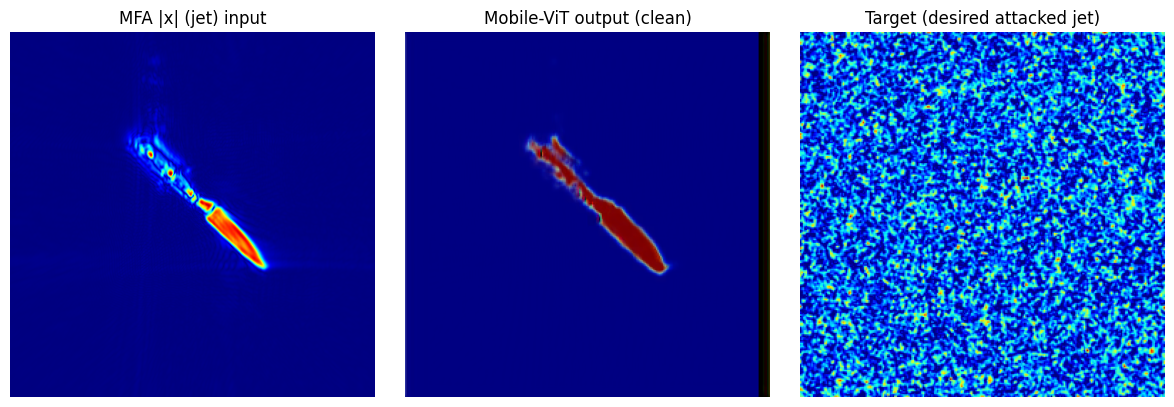

In [ ]:
# ============================================================
# 5. Build attack target from desired_attacked_complex (401x401)
# ============================================================
mat_des = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/desired_attacked_complex.mat")
des_np = mat_des["sar_camouflaged"]   # (401,401) complex; adjust key if needed
print("desired_attacked_complex shape:", des_np.shape, des_np.dtype)

des_torch = torch.from_numpy(des_np).to(torch.complex64).to(device)

# magnitude + RMS norm
des_mag = torch.abs(des_torch)
rms_des = torch.sqrt(torch.mean(des_mag**2) + 1e-12)
des_mag_norm = des_mag / rms_des          # (401,401)

# min-max to [0,1]
x_des = des_mag_norm
x_des = x_des - x_des.min()
x_des = x_des / (x_des.max() + 1e-8)

# jet + resize to (256,256)
des_rgb = jet_torch(x_des)                   # (3,H,W)
des_rgb = des_rgb.unsqueeze(0)               # (1,3,H,W)
target_tensor = F.interpolate(
    des_rgb, size=(256,256),
    mode='bilinear', align_corners=False
).detach()                                   # (1,3,256,256)
print("target_tensor shape:", target_tensor.shape)


# ============================================================
# 6. Sanity check: clean victim output vs target
# ============================================================
with torch.no_grad():
    sr_clean, rgb_in_clean, mfa_mag_clean = victim_forward(raw_cube, params, model)

sr_img = sr_clean[0].detach().cpu().permute(1,2,0).numpy()
sr_img = np.clip(sr_img, 0.0, 1.0)

clean_rgb_vis = rgb_in_clean[0].detach().cpu().permute(1,2,0).numpy()
clean_rgb_vis = np.clip(clean_rgb_vis, 0.0, 1.0)

target_img = target_tensor[0].detach().cpu().permute(1,2,0).numpy()
target_img = np.clip(target_img, 0.0, 1.0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(clean_rgb_vis); plt.title("MFA |x| (jet) input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(sr_img);        plt.title("Mobile-ViT output (clean)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(target_img);    plt.title("Target (desired attacked jet)"); plt.axis('off')
plt.tight_layout(); plt.show()

D.mat was generated in MATLAB from iqData_noAtk / iqData_Atk and rawSAR. Here in Python, D (shape Nsamp x Np) is used as the fixed base attack waveform that will be combined with learnable gains A over the rawSAR measurements before running the differentiable MFA + Mobile-ViT pipeline.

In [ ]:
import scipy.io as sio
import torch.nn.functional as F

# ============================================================
# 6. Load D from MATLAB and reshape to match raw_cube
# ============================================================
mat_D = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Mobile_VIT_UTdallas/D.mat")
D_np  = mat_D["D"]              # shape: (Nsamp, Np), complex from MATLAB

# Convert to torch complex and move to device
D = torch.from_numpy(D_np).to(torch.complex64).to(device)  # (Nsamp, Np)

Nsamp_D, Np_D = D.shape
Nsamp, M, N   = raw_cube.shape      # raw_cube: (Nsamp, M, N)

assert Nsamp_D == Nsamp, f"Nsamp mismatch: D={Nsamp_D}, raw_cube={Nsamp}"
assert Np_D    == M * N, f"Np mismatch: D={Np_D}, M*N={M*N}"

# Reshape to cube so each aperture location (m,n) has its own attack waveform over fast-time
D_cube = D.view(Nsamp, M, N)        # (Nsamp, M, N)

print("D_cube shape:", D_cube.shape)   # (Nsamp, M, N)

D_cube shape: torch.Size([256, 200, 200])


In [ ]:
# ============================================================
# 7. Attack: optimize complex gain A over D_cube
#     Δ(t,m,n) = D_cube(t,m,n) * A(m,n)
# ============================================================
# Complex gain per aperture location
A_re = torch.zeros(M, N, device=device, requires_grad=True)
A_im = torch.zeros(M, N, device=device, requires_grad=True)

optimizer = torch.optim.Adam([A_re, A_im], lr=1e-5)
lambda_L2 = 1e-4      # regularization on A
num_iters = 200
Amax      = 2.0       # optional magnitude cap on A

for it in range(1, num_iters + 1):
    optimizer.zero_grad()

    # Build complex gain map A and corresponding perturbation Δ
    A = torch.complex(A_re, A_im)             # (M, N)
    delta = D_cube * A.unsqueeze(0)           # (Nsamp, M, N), broadcast over fast-time

    # Optional projection: cap |A| elementwise (keeps relation Δ = D·A intact)
    if Amax is not None:
        with torch.no_grad():
            magA = torch.abs(A)               # (M, N)
            over = magA > Amax
            if over.any():
                scale = Amax / (magA[over] + 1e-12)
                A_re.data[over] *= scale
                A_im.data[over] *= scale

    # Rebuild A (after projection) and delta to keep them consistent
    A = torch.complex(A_re, A_im)
    delta = D_cube * A.unsqueeze(0)           # (Nsamp, M, N)

    # Attacked raw data
    raw_adv = raw_cube + delta                # (Nsamp, M, N)

    # Pass through victim: rawSAR (complex) → MFA (torch, autograd) → jet RGB → Mobile-ViT
    sr_adv, _, _ = victim_forward(raw_adv, params, model)   # sr_adv: (1,3,256,256) or similar

    # Image loss in jet-RGB space
    loss_img = F.mse_loss(sr_adv, target_tensor)

    # L2 regularization on A (not directly on Δ)
    loss_reg = lambda_L2 * (A_re.pow(2).mean() + A_im.pow(2).mean())

    loss = loss_img + loss_reg
    loss.backward()
    optimizer.step()

    if it % 10 == 0 or it == 1 or it == num_iters:
        with torch.no_grad():
            mse_now   = F.mse_loss(sr_adv, target_tensor).item()
            meanA     = torch.mean(torch.abs(A)).item()
            maxA      = torch.max(torch.abs(A)).item()
        print(f"Iter {it:03d}/{num_iters} | "
              f"Loss={loss.item():.4e} | ImgMSE={mse_now:.4e} | "
              f"mean|A|={meanA:.3e}, max|A|={maxA:.3e}")

print("Attack optimization done.")

Iter 001/200 | Loss=1.6167e-01 | ImgMSE=1.6167e-01 | mean|A|=0.000e+00, max|A|=0.000e+00
Iter 010/200 | Loss=1.6167e-01 | ImgMSE=1.6167e-01 | mean|A|=5.499e-05, max|A|=1.238e-04
Iter 020/200 | Loss=1.6166e-01 | ImgMSE=1.6166e-01 | mean|A|=9.639e-05, max|A|=2.276e-04
Iter 030/200 | Loss=1.6166e-01 | ImgMSE=1.6166e-01 | mean|A|=1.373e-04, max|A|=3.226e-04
Iter 040/200 | Loss=1.6165e-01 | ImgMSE=1.6165e-01 | mean|A|=1.785e-04, max|A|=4.285e-04
Iter 050/200 | Loss=1.6165e-01 | ImgMSE=1.6165e-01 | mean|A|=2.200e-04, max|A|=5.278e-04
Iter 060/200 | Loss=1.6165e-01 | ImgMSE=1.6165e-01 | mean|A|=2.615e-04, max|A|=6.214e-04
Iter 070/200 | Loss=1.6164e-01 | ImgMSE=1.6164e-01 | mean|A|=3.032e-04, max|A|=7.136e-04
Iter 080/200 | Loss=1.6164e-01 | ImgMSE=1.6164e-01 | mean|A|=3.449e-04, max|A|=8.196e-04
Iter 090/200 | Loss=1.6163e-01 | ImgMSE=1.6163e-01 | mean|A|=3.868e-04, max|A|=9.266e-04
Iter 100/200 | Loss=1.6163e-01 | ImgMSE=1.6163e-01 | mean|A|=4.285e-04, max|A|=1.028e-03
Iter 110/200 | Loss=1

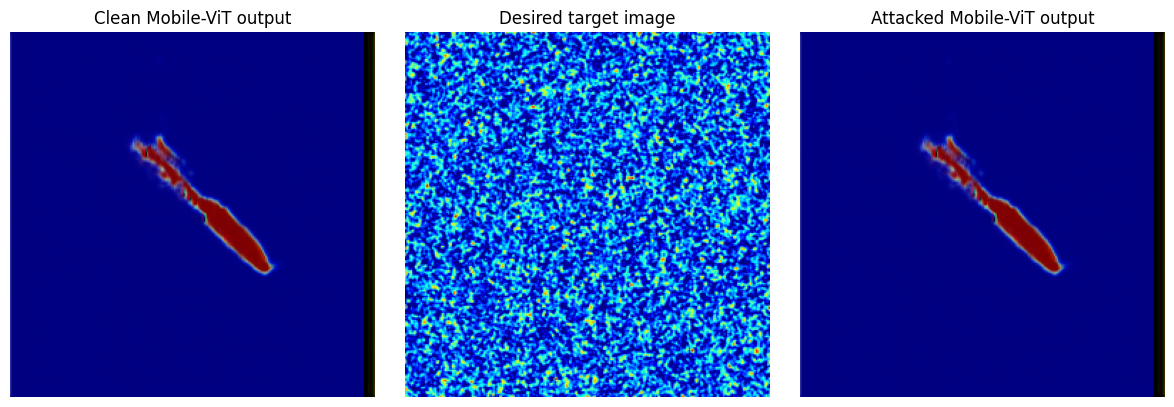

In [ ]:
# ============================================================
# 8. Visualize final attacked image
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # Clean pipeline (no attack)
    sr_clean, _, _ = victim_forward(raw_cube, params, model)   # (1,3,H,W)
    # Attacked pipeline (with optimal A / D_cube)
    sr_att,   _, _ = victim_forward(raw_adv, params, model)    # (1,3,H,W)

# Convert to numpy [0,1]
sr_clean_np = sr_clean[0].permute(1, 2, 0).cpu().numpy()
sr_att_np   = sr_att[0].permute(1, 2, 0).cpu().numpy()
tgt_np      = target_tensor[0].permute(1, 2, 0).cpu().numpy()

sr_clean_np = np.clip(sr_clean_np, 0.0, 1.0)
sr_att_np   = np.clip(sr_att_np,   0.0, 1.0)
tgt_np      = np.clip(tgt_np,      0.0, 1.0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(sr_clean_np)
plt.title("Clean Mobile-ViT output")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(tgt_np)
plt.title("Desired target image")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sr_att_np)
plt.title("Attacked Mobile-ViT output")
plt.axis('off')

plt.tight_layout()
plt.show()
